# DESCRIPTION
This notebook processes and visualizes results from the grid models (baseline ["bl"], monthly avg ["avg"], and onehot ["oh"])

In [1]:
"""
    LOAD LIBRARIES
"""
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pyproj
import rioxarray as rxr
import datetime
import pandas as pd
import tensorflow as tf
from numpy import inf

2022-09-12 13:05:41.253863: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
"""
    EXAMPLE DATASET
"""
## load input data ##
ds_output_dir = '/glade/scratch/rossamower/snow/snowmodel/aso/california/tuolumne/snowmodel/cheyenne/outputs/aso_sm/'
ds = xr.load_dataset(ds_output_dir + 'aso_sm_merge_clean_2.nc')

## path for output ##
path = '/glade/scratch/rossamower/snow/snowmodel/aso/california/tuolumne/snowmodel/cheyenne/outputs/aso_sm/ml_results/grid/ln/'

## dictionary for 1D decomposition [parallelization] ##
# me_dict = {0:[0,101],
#            1:[101,201],
#            2:[201,301],
#            3:[301,401],
#            4:[401,501],
#            5:[501,601],
#            6:[601,701],
#            7:[701,801],
#            8:[801,901],
#            9:[901,1001],
#            10:[1001,1046],
# }
me_dict = {}
counter = 0
for i in range(0,21):
    i_start = counter
    if i == 0:
        i_end = counter + 51
        me_dict[i] = [i_start,i_end]
    elif i == 20:
        i_end = counter + 45
        me_dict[i] = [i_start,i_end]
    else:
        i_end = counter + 50
        me_dict[i] = [i_start,i_end]
    counter = i_end
    
for k,v in me_dict.items():
    print(f'{k} : {v}')
ds

<xarray.Dataset>
Dimensions:        (y: 1006, x: 1046, time: 50)
Coordinates:
  * y              (y) float64 4.179e+06 4.179e+06 ... 4.23e+06 4.23e+06
  * x              (x) float64 2.543e+05 2.543e+05 ... 3.065e+05 3.065e+05
  * time           (time) datetime64[ns] 2013-04-03T23:00:00 ... 2020-05-22T2...
Data variables:
    sm_swe         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    aso_swe        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    notGrid        (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    hgt            (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    veg            (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    veg_bin        (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    aspect         (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    slope          (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    asp_x_slp      (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    elev_bin       (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    asp_x_slp_bin  (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

In [4]:

counter = 0
for i in range(0,21):
    i_start = counter
    if i == 0:
        i_end = counter + 51
        me_dict_2[i] = [i_start,i_end]
    elif i == 20:
        i_end = counter + 45
        me_dict_2[i] = [i_start,i_end]
    else:
        i_end = counter + 50
        me_dict_2[i] = [i_start,i_end]
    counter = i_end
    
for k,v in me_dict_2.items():
    print(f'{k} : {v}')

0 : [0, 51]
1 : [51, 101]
2 : [101, 151]
3 : [151, 201]
4 : [201, 251]
5 : [251, 301]
6 : [301, 351]
7 : [351, 401]
8 : [401, 451]
9 : [451, 501]
10 : [501, 551]
11 : [551, 601]
12 : [601, 651]
13 : [651, 701]
14 : [701, 751]
15 : [751, 801]
16 : [801, 851]
17 : [851, 901]
18 : [901, 951]
19 : [951, 1001]
20 : [1001, 1046]


In [3]:
def np_stitch(fname,t_dim,path):
    """
        FUCNTION CONCATENATES RESULTS FROM RUNNING MODELS IN PARALLEL
    """
    for k,v in me_dict.items():
        np_1d = np.fromfile(f'{path}{fname}_{str(k)}_.gdat')
        np_3d = np_1d.reshape(t_dim,ds.y.shape[0],v[1]-v[0],order = 'F')
        if k == 0:
            np_conc = np_3d
        else:
            np_conc = np.concatenate((np_conc,np_3d),axis = 2)
    return np_conc

In [4]:
def summary_stats(ds,da,tslice,isPrediction=True):
    """
        SUMMARY STATISTICS FOR VALIDATION ON 2019-2020 
    """
    ## diff ##
    avg_diff = (ds.aso_swe[tslice:,:,:] - ds[da][tslice:,:,:]).mean(dim = 'time',skipna = True).mean(skipna = True).values
    max_diff = (ds.aso_swe[tslice:,:,:] - ds[da][tslice:,:,:]).mean(dim = 'time',skipna = True).max(skipna = True).values
    min_diff = (ds.aso_swe[tslice:,:,:] - ds[da][tslice:,:,:]).mean(dim = 'time',skipna = True).min(skipna = True).values
    ## mse ##
    avg_mse =  ((((ds.aso_swe[tslice:,:,:] - ds[da][tslice:,:,:])**2).sum(dim = 'time',skipna = True))/(ds.time[tslice:].shape[0])).mean(skipna = True).values
    min_mse =  ((((ds.aso_swe[tslice:,:,:] - ds[da][tslice:,:,:])**2).sum(dim = 'time',skipna = True))/(ds.time[tslice:].shape[0])).min(skipna = True).values
    max_mse =  ((((ds.aso_swe[tslice:,:,:] - ds[da][tslice:,:,:])**2).sum(dim = 'time',skipna = True))/(ds.time[tslice:].shape[0])).max(skipna = True).values
    ## rmse ##
    avg_rmse =  np.sqrt((((ds.aso_swe[tslice:,:,:] - ds[da][tslice:,:,:])**2).sum(dim = 'time',skipna = True))/(ds.time[tslice:].shape[0])).mean(skipna = True).values
    min_rmse =  np.sqrt((((ds.aso_swe[tslice:,:,:] - ds[da][tslice:,:,:])**2).sum(dim = 'time',skipna = True))/(ds.time[tslice:].shape[0])).min(skipna = True).values
    max_rmse =  np.sqrt((((ds.aso_swe[tslice:,:,:] - ds[da][tslice:,:,:])**2).sum(dim = 'time',skipna = True))/(ds.time[tslice:].shape[0])).max(skipna = True).values
    ## r2 ##
    if isPrediction == True:
        avg_r2 = ds.r2.mean(dim = 'iter',skipna = True).mean(skipna = True).values
        min_r2 = ds.r2.mean(dim = 'iter',skipna = True).min(skipna = True).values
        max_r2 = ds.r2.mean(dim = 'iter',skipna = True).max(skipna = True).values
        
          
    ## print statements ##
    print('ASO - SNOWMODEL [DIFF]')
    print(f'average :{avg_diff}')
    print(f'max :{max_diff}')
    print(f'min :{min_diff}')
    print('')
    print('ASO - SNOWMODEL [MSE]')
    print(f'average :{avg_mse}')
    print(f'max :{max_mse}')
    print(f'min :{min_mse}')
    print('')
    print('ASO - SNOWMODEL [RMSE]')
    print(f'average :{avg_rmse}')
    print(f'max :{max_rmse}')
    print(f'min :{min_rmse}')
    if isPrediction == True:
        print('')
        print('ASO - SNOWMODEL [R2]')
        print(f'average :{avg_r2}')
        print(f'max :{max_r2}')
        print(f'min :{min_r2}')
        
        print(f'Avg Training R2 : {ds.r2[-2,:,:].mean(skipna = True).values}')
        print(f'Avg Testing R2 : {ds.r2[-3,:,:].mean(skipna = True).values}')

In [5]:
"""
    CREATE DICTIONARY OF VARIABLES AND DIMENSIONS
"""
dic_bl = {'yhat':['bl_yhat_ln', 33],
          'r2':['bl_r2_ln', 3],
          'bias':['bl_bias_ln', 3],
          'coef':['bl_coef_ln', 1],
          }
dic_oh = {'yhat':['oh_yhat_ln', 33],
          'r2':['oh_r2_ln', 3],
          'bias':['oh_bias_ln', 3],
          'coef':['oh_coef_ln', 6],
          }
dic_avg = {'yhat':['bl_yhat_ln', 23],
          'aso_swe':['bl_aso_ln', 23],
          'sm_swe':['bl_sm_ln', 23],
          'r2':['bl_r2_ln', 3],
          'bias':['bl_bias_ln', 3],
          'coef':['bl_coef_ln', 1],
          }

In [6]:
"""
    CREATE BL VARIABLES
"""
np_bl_yhat = np_stitch(dic_bl['yhat'][0],dic_bl['yhat'][1],path + 'baseline/')
np_bl_r2 = np_stitch(dic_bl['r2'][0],dic_bl['r2'][1],path + 'baseline/')
np_bl_bias = np_stitch(dic_bl['bias'][0],dic_bl['bias'][1],path + 'baseline/')
np_bl_coef = np_stitch(dic_bl['coef'][0],dic_bl['coef'][1],path + 'baseline/')

## for visualization purposes set values outside ranges to nan ##
np_bl_r2[np_bl_r2 < 0.0] = np.nan
np_bl_r2[np_bl_r2 > 1.0] = np.nan
np_bl_yhat[np_bl_yhat == -inf] = np.nan
np_bl_yhat[np_bl_yhat == inf] = np.nan
np_bl_yhat[np_bl_yhat < -0.01] = np.nan
np_bl_yhat[np_bl_yhat > 15] = np.nan

## process variables and create xarray dataset ##
time = ds.time[17:].values 
sm_swe = ds.sm_swe[17:,:,:].values 
aso_swe = ds.aso_swe[17:,:,:].values
notGrid = ds.notGrid.values
veg = ds.veg.values
hgt = ds.hgt.values
x = ds.x.values 
y = ds.y.values

model_iter = np.arange(start = 0,stop = len(np_bl_r2))
coef = np.arange(start = 0,stop = len(np_bl_coef))

ds_bl = xr.Dataset(
    data_vars = dict(
        aso_swe = (["time","y","x"],aso_swe),
        sm_swe = (["time","y","x"],sm_swe),
        yhat = (["time","y","x"],np_bl_yhat),
        r2 = (["iter","y","x"],np_bl_r2),
        bias = (["iter","y","x"],np_bl_bias),
        coef = (["coef_val","y","x"],np_bl_coef),
        notGrid = (["y","x"],notGrid),
        veg = (["y","x"],veg),
        hgt = (["y","x"],hgt),
    ),
            coords={"time": ("time",time),
                "y": (("y"),y),
                "x": (("x"),x),
                "iter": (("iter"),model_iter),
                "coef_val": (("coef_val"),coef),
                    
                
                })

In [7]:
"""
    CREATE OH VARIABLES
"""
np_bl_yhat = np_stitch(dic_oh['yhat'][0],dic_oh['yhat'][1],path + 'onehot/')
np_bl_r2 = np_stitch(dic_oh['r2'][0],dic_oh['r2'][1],path + 'onehot/')
np_bl_bias = np_stitch(dic_oh['bias'][0],dic_oh['bias'][1],path + 'onehot/')
np_bl_coef = np_stitch(dic_oh['coef'][0],dic_oh['coef'][1],path + 'onehot/')

## for visualization purposes set values outside ranges to nan ##
np_bl_r2[np_bl_r2 < 0.0] = np.nan
np_bl_r2[np_bl_r2 > 1.0] = np.nan
np_bl_yhat[np_bl_yhat == -inf] = np.nan
np_bl_yhat[np_bl_yhat == inf] = np.nan
np_bl_yhat[np_bl_yhat < -0.01] = np.nan
np_bl_yhat[np_bl_yhat > 15] = np.nan

## process variables and create xarray dataset ##
time = ds.time[17:].values 
sm_swe = ds.sm_swe[17:,:,:].values 
aso_swe = ds.aso_swe[17:,:,:].values
notGrid = ds.notGrid.values
veg = ds.veg.values
hgt = ds.hgt.values
x = ds.x.values 
y = ds.y.values

model_iter = np.arange(start = 0,stop = len(np_bl_r2))
coef = np.arange(start = 0,stop = len(np_bl_coef))

ds_oh = xr.Dataset(
    data_vars = dict(
        aso_swe = (["time","y","x"],aso_swe),
        sm_swe = (["time","y","x"],sm_swe),
        yhat = (["time","y","x"],np_bl_yhat),
        r2 = (["iter","y","x"],np_bl_r2),
        bias = (["iter","y","x"],np_bl_bias),
        coef = (["coef_val","y","x"],np_bl_coef),
        notGrid = (["y","x"],notGrid),
        veg = (["y","x"],veg),
        hgt = (["y","x"],hgt),
    ),
            coords={"time": ("time",time),
                "y": (("y"),y),
                "x": (("x"),x),
                "iter": (("iter"),model_iter),
                "coef_val": (("coef_val"),coef),
                    
                
                })

In [8]:
"""
    CREATE AVG VARIABLES
"""
np_bl_yhat = np_stitch(dic_avg['yhat'][0],dic_avg['yhat'][1],path + 'month_avg/')
np_bl_r2 = np_stitch(dic_avg['r2'][0],dic_avg['r2'][1],path + 'month_avg/')
np_bl_bias = np_stitch(dic_avg['bias'][0],dic_avg['bias'][1],path + 'month_avg/')
np_bl_coef = np_stitch(dic_avg['coef'][0],dic_avg['coef'][1],path + 'month_avg/')
np_bl_sm = np_stitch(dic_avg['sm_swe'][0],dic_avg['sm_swe'][1],path + 'month_avg/')
np_bl_aso = np_stitch(dic_avg['aso_swe'][0],dic_avg['aso_swe'][1],path + 'month_avg/')

## for visualization purposes set values outside ranges to nan ##
np_bl_r2[np_bl_r2 < 0.0] = np.nan
np_bl_r2[np_bl_r2 > 1.0] = np.nan
np_bl_yhat[np_bl_yhat == -inf] = np.nan
np_bl_yhat[np_bl_yhat == inf] = np.nan
np_bl_yhat[np_bl_yhat < -0.01] = np.nan
np_bl_yhat[np_bl_yhat > 15] = np.nan

## create pd datatime that is grouped by year and month to join data to ##
date_pd = pd.DataFrame({'time':pd.to_datetime(ds.time[:].values)})#,
date_pd = date_pd[date_pd.time.dt.year.isin([2015,2016,2017,2018,2019,2020])]
date_pd['month_year'] = date_pd['time'].dt.to_period('M')
date_pd['blank'] = 1
df_new = pd.DataFrame(date_pd.groupby('month_year')['blank'].mean())
df_new = df_new.reset_index()
df_new['Month'] = df_new['month_year'].astype(str)
df_new['Month'] = pd.to_datetime(df_new['Month'])
df_new

## process variables and create xarray dataset ##
notGrid = ds.notGrid.values
veg = ds.veg.values
hgt = ds.hgt.values
x = ds.x.values 
y = ds.y.values

model_iter = np.arange(start = 0,stop = len(np_bl_r2))
coef = np.arange(start = 0,stop = len(np_bl_coef))

ds_avg = xr.Dataset(
    data_vars = dict(
        aso_swe = (["time","y","x"],np_bl_aso),
        sm_swe = (["time","y","x"],np_bl_sm),
        yhat = (["time","y","x"],np_bl_yhat),
        r2 = (["iter","y","x"],np_bl_r2),
        bias = (["iter","y","x"],np_bl_bias),
        coef = (["coef_val","y","x"],np_bl_coef),
        notGrid = (["y","x"],notGrid),
        veg = (["y","x"],veg),
        hgt = (["y","x"],hgt),
    ),
            coords={"time": ("time",df_new.Month),
                "y": (("y"),y),
                "x": (("x"),x),
                "iter": (("iter"),model_iter),
                "coef_val": (("coef_val"),coef),
                    
                
                })

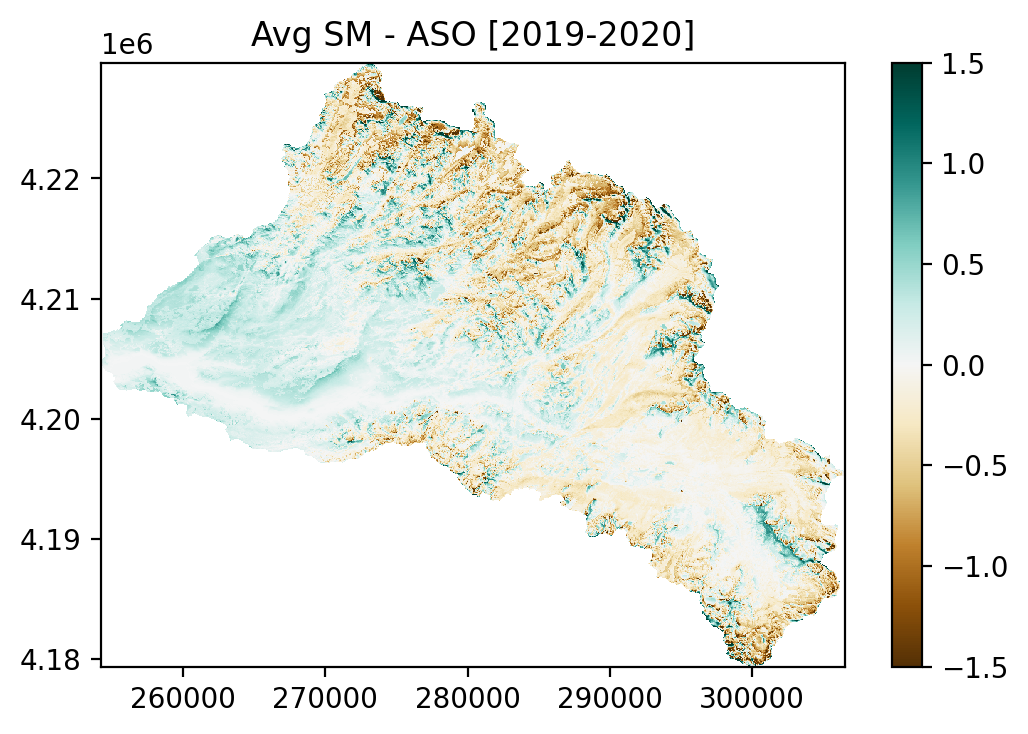

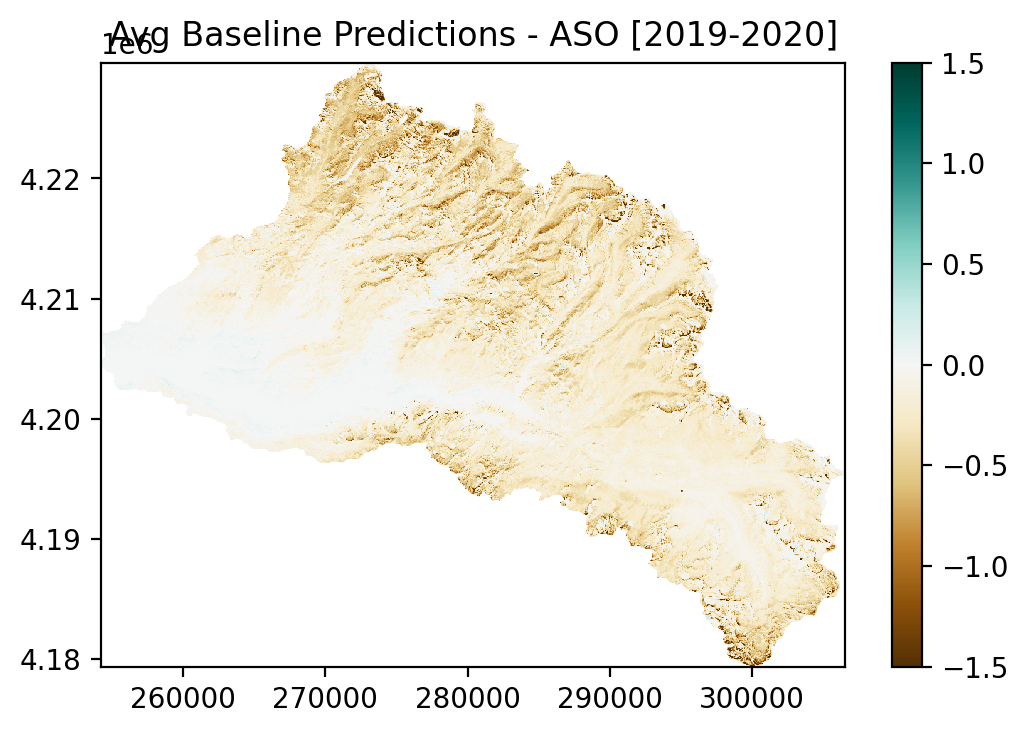

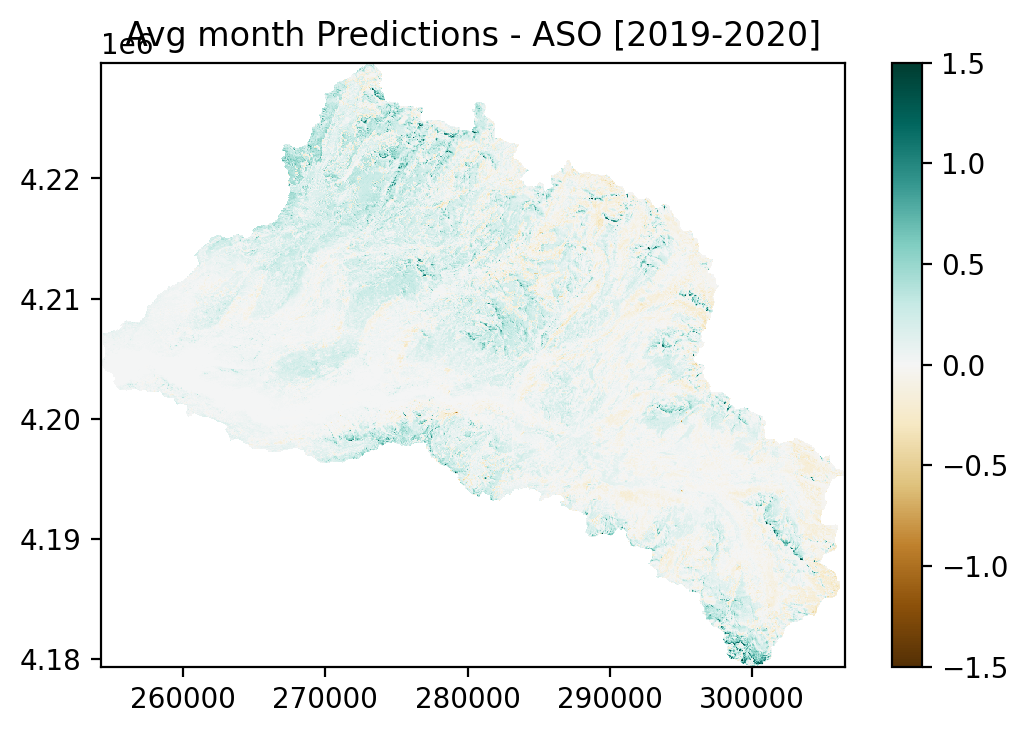

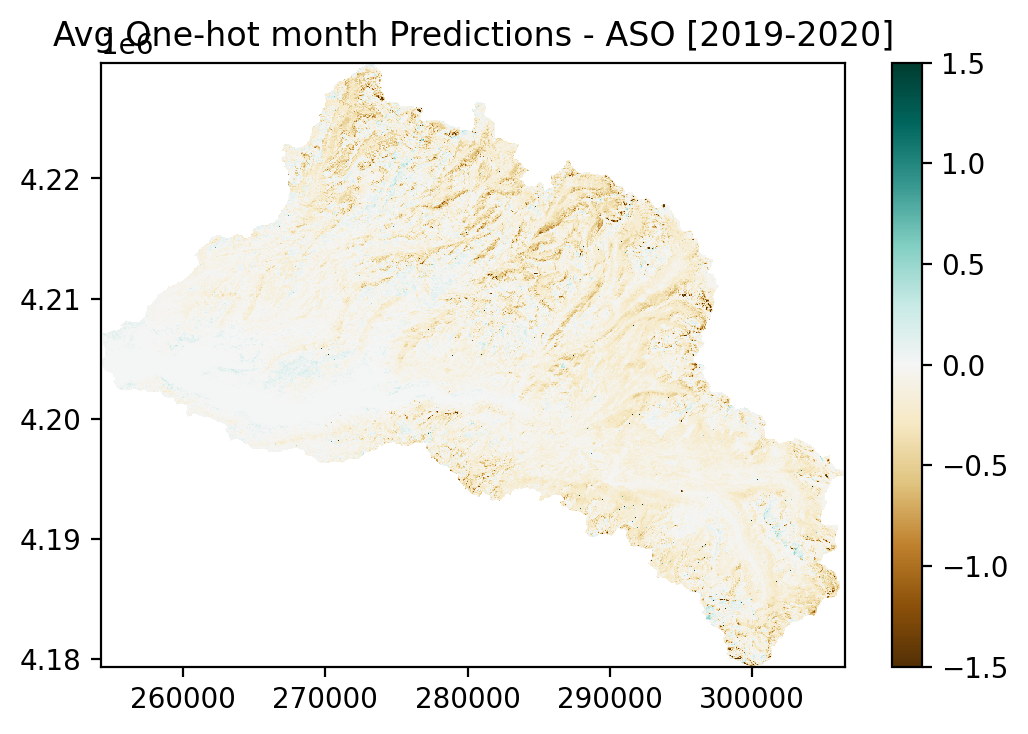

In [9]:
"""
    SPATIAL VISUALIZATION
"""

fig,ax = plt.subplots(dpi = 200)
plt.pcolormesh(ds_bl.x,ds_bl.y,(ds_bl.sm_swe[-8:] - ds_bl.aso_swe[-8:]).mean(dim = 'time',skipna = True),cmap = 'BrBG',vmin = -1.5,vmax = 1.5)
plt.title('Avg SM - ASO [2019-2020]')
plt.colorbar()


fig,ax = plt.subplots(dpi = 200)
plt.pcolormesh(ds_bl.x,ds_bl.y,(ds_bl.yhat[-8:] - ds_bl.aso_swe[-8:]).mean(dim = 'time',skipna = True),cmap = 'BrBG',vmin = -1.5,vmax = 1.5)
plt.title('Avg Baseline Predictions - ASO [2019-2020]')
plt.colorbar()

fig,ax = plt.subplots(dpi = 200)
plt.pcolormesh(ds_avg.x,ds_avg.y,(ds_avg.yhat[-7:] - ds_avg.aso_swe[-7:]).mean(dim = 'time',skipna = True),cmap = 'BrBG',vmin = -1.5,vmax = 1.5)
plt.title('Avg month Predictions - ASO [2019-2020]')
plt.colorbar()

fig,ax = plt.subplots(dpi = 200)
plt.pcolormesh(ds_oh.x,ds_oh.y,(ds_oh.yhat[-8:] - ds_oh.aso_swe[-8:]).mean(dim = 'time',skipna = True),cmap = 'BrBG',vmin = -1.5,vmax = 1.5)
plt.title('Avg One-hot month Predictions - ASO [2019-2020]')
plt.colorbar()


Text(0.5, 1.0, 'Average SWE OH vs. ASO\n 2019-2020')

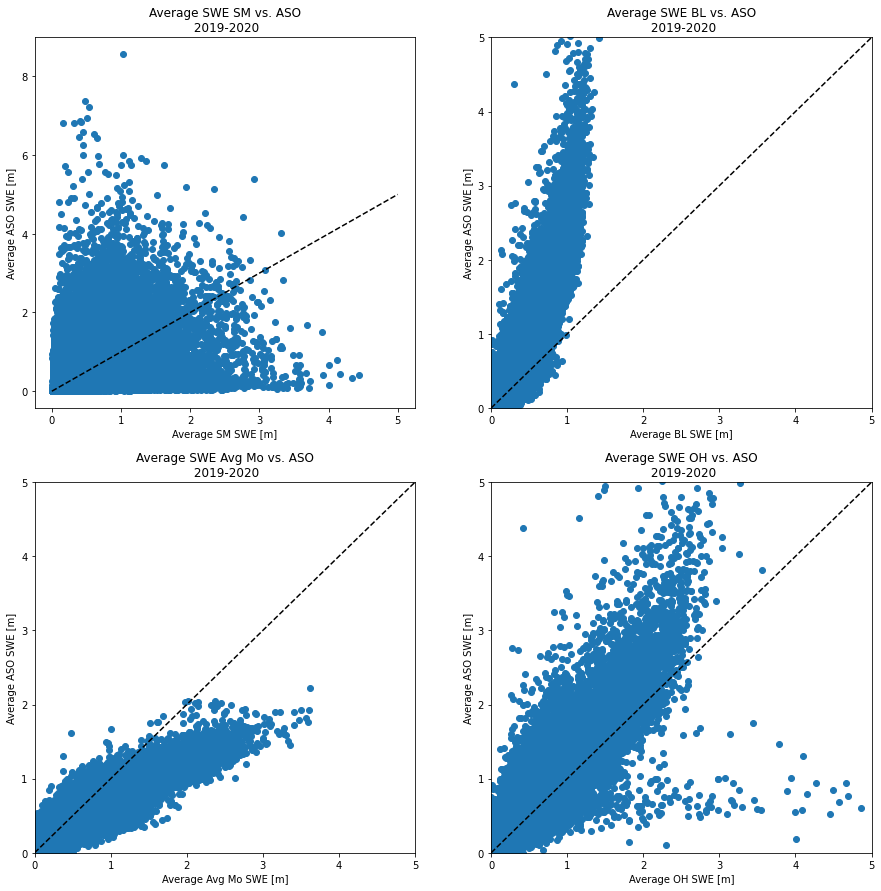

In [10]:
"""
    AGGREGATE OUTPUT COMPARISON
"""

fig,ax = plt.subplots(2,2,figsize = (15,15))
ax[0][0].scatter(ds_bl.sm_swe[-8:].mean(dim = 'time',skipna = True),ds_bl.aso_swe[-8:].mean(dim = 'time',skipna = True))
ax[0][0].plot(np.arange(0,6),np.arange(0,6),'--',color = 'black')
ax[0][0].set_ylabel('Average ASO SWE [m]')
ax[0][0].set_xlabel('Average SM SWE [m]')
ax[0][0].set_title('Average SWE SM vs. ASO\n 2019-2020')



ax[0][1].scatter(ds_bl.yhat[-8:].mean(dim = 'time',skipna = True),ds_bl.aso_swe[-8:].mean(dim = 'time',skipna = True))
ax[0][1].plot(np.arange(0,6),np.arange(0,6),'--',color = 'black')
ax[0][1].set_ylabel('Average ASO SWE [m]')
ax[0][1].set_xlabel('Average BL SWE [m]')
ax[0][1].set_xlim([0, 5])
ax[0][1].set_ylim([0,5])
ax[0][1].set_title('Average SWE BL vs. ASO\n 2019-2020')

ax[1][0].scatter(ds_avg.yhat[-7:].mean(dim = 'time',skipna = True),ds_avg.aso_swe[-7:].mean(dim = 'time',skipna = True))
ax[1][0].plot(np.arange(0,6),np.arange(0,6),'--',color = 'black')
ax[1][0].set_ylabel('Average ASO SWE [m]')
ax[1][0].set_xlabel('Average Avg Mo SWE [m]')
ax[1][0].set_xlim([0, 5])
ax[1][0].set_ylim([0,5])
ax[1][0].set_title('Average SWE Avg Mo vs. ASO\n 2019-2020')

ax[1][1].scatter(ds_oh.yhat[-8:].mean(dim = 'time',skipna = True),ds_oh.aso_swe[-8:].mean(dim = 'time',skipna = True))
ax[1][1].plot(np.arange(0,6),np.arange(0,6),'--',color = 'black')
ax[1][1].set_ylabel('Average ASO SWE [m]')
ax[1][1].set_xlabel('Average OH SWE [m]')
ax[1][1].set_xlim([0, 5])
ax[1][1].set_ylim([0,5])
ax[1][1].set_title('Average SWE OH vs. ASO\n 2019-2020')

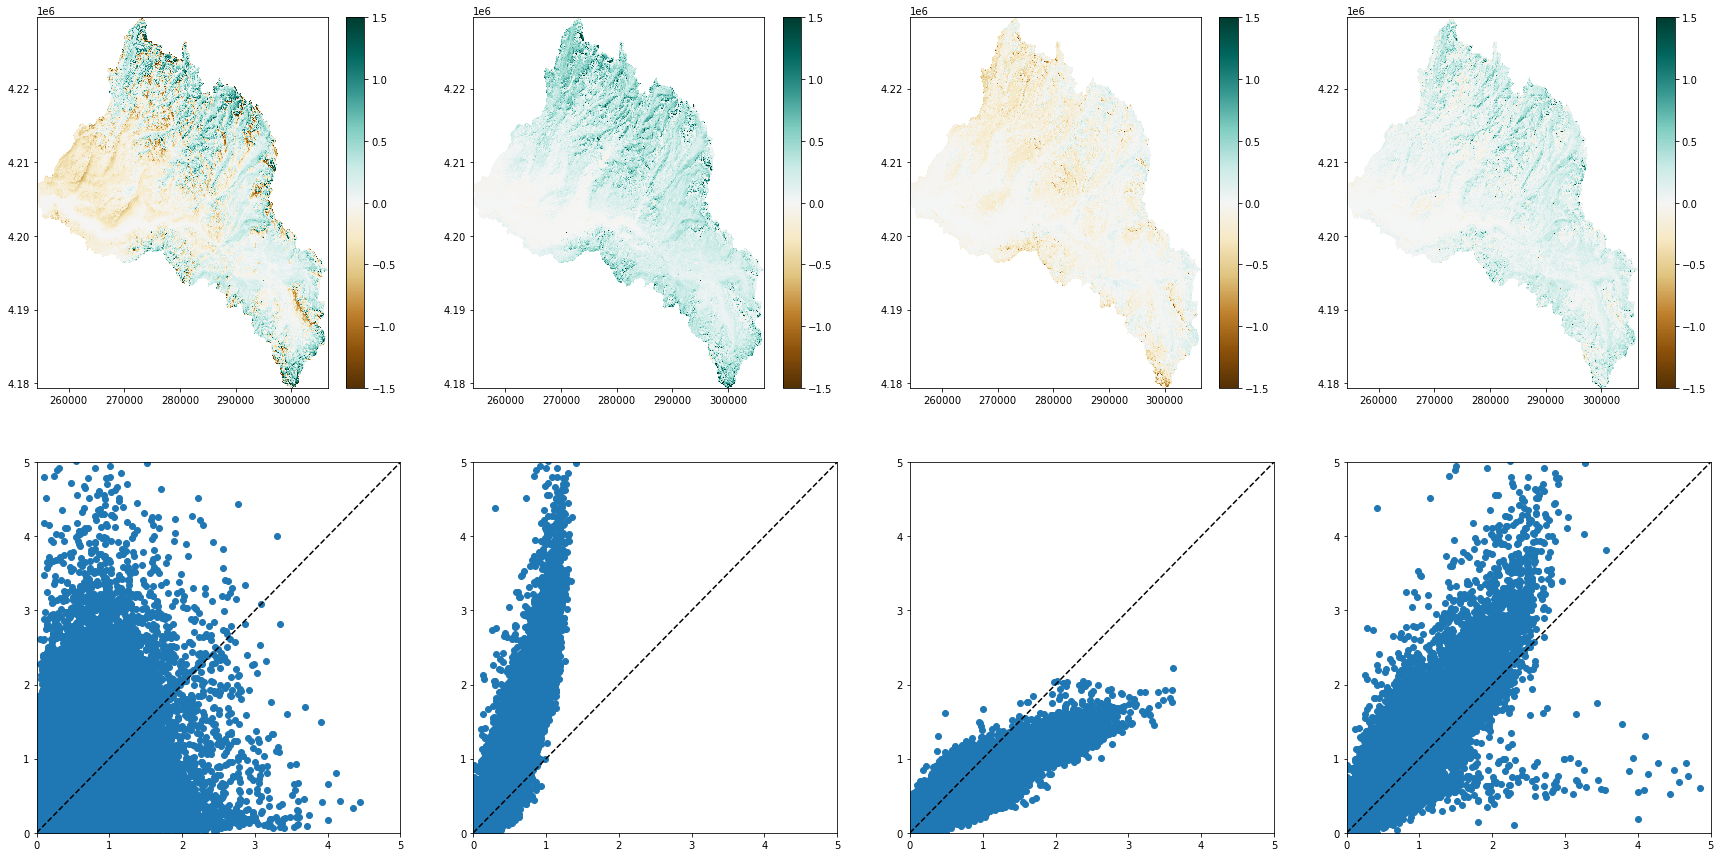

In [11]:
"""
    SPATIAL AND AGGREGATE OUTPUT COMPARISON
"""

fig,ax = plt.subplots(2,4,figsize = (30,15))

## sm swe vs aso swe##
a = ax[0][0].pcolormesh(ds_bl.x,ds_bl.y,(ds_bl.aso_swe[-8:] - ds_bl.sm_swe[-8:]).mean(dim = 'time',skipna = True),cmap = 'BrBG',vmin = -1.5,vmax = 1.5)
# ax[0][0].set_ylabel('utm - y')
# ax[0][0].set_xlabel('utm - x')
plt.colorbar(a,ax=ax[0][0])
# ax[0][0].set_title('Average ASO SWE vs. SM SWE\n 2019-2020')

ax[1][0].scatter(ds_bl.sm_swe[-8:].mean(dim = 'time',skipna = True),ds_bl.aso_swe[-8:].mean(dim = 'time',skipna = True))
ax[1][0].plot(np.arange(0,6),np.arange(0,6),'--',color = 'black')
# ax[1][0].set_ylabel('Average ASO SWE [m]')
# ax[1][0].set_xlabel('Average SM SWE [m]')
ax[1][0].set_xlim([0, 5])
ax[1][0].set_ylim([0,5])
# ax[1][0].set_title('Average SWE SM vs. ASO\n 2019-2020')

## bl vs aso swe##
a = ax[0][1].pcolormesh(ds_bl.x,ds_bl.y,(ds_bl.aso_swe[-8:] - ds_bl.yhat[-8:]).mean(dim = 'time',skipna = True),cmap = 'BrBG',vmin = -1.5,vmax = 1.5)
# ax[0][1].set_ylabel('utm - y')
# ax[0][1].set_xlabel('utm - x')
plt.colorbar(a,ax=ax[0][1])
# ax[0][1].set_title('Average ASO SWE vs. BL SWE\n 2019-2020')

ax[1][1].scatter(ds_bl.yhat[-8:].mean(dim = 'time',skipna = True),ds_bl.aso_swe[-8:].mean(dim = 'time',skipna = True))
ax[1][1].plot(np.arange(0,6),np.arange(0,6),'--',color = 'black')
# ax[1][1].set_ylabel('Average ASO SWE [m]')
# ax[1][1].set_xlabel('Average BL SWE [m]')
ax[1][1].set_xlim([0, 5])
ax[1][1].set_ylim([0,5])
# ax[1][1].set_title('Average SWE BL vs. ASO\n 2019-2020')


a = ax[0][2].pcolormesh(ds_avg.x,ds_avg.y,(ds_avg.aso_swe[-7:] - ds_avg.yhat[-7:]).mean(dim = 'time',skipna = True),cmap = 'BrBG',vmin = -1.5,vmax = 1.5)
# ax[0][2].set_ylabel('utm - y')
# ax[0][2].set_xlabel('utm - x')
plt.colorbar(a,ax=ax[0][2])
# ax[0][2].set_title('Average ASO SWE vs. Mo Avg SWE vs. ASO\n 2019-2020')

ax[1][2].scatter(ds_avg.yhat[-7:].mean(dim = 'time',skipna = True),ds_avg.aso_swe[-7:].mean(dim = 'time',skipna = True))
ax[1][2].plot(np.arange(0,6),np.arange(0,6),'--',color = 'black')
# ax[1][2].set_ylabel('Average ASO SWE [m]')
# ax[1][2].set_xlabel('Average Avg Mo SWE [m]')
ax[1][2].set_xlim([0, 5])
ax[1][2].set_ylim([0,5])
# ax[1][2].set_title('Average ASO SWE vs. Avg Mo SWE\n 2019-2020')


a = ax[0][3].pcolormesh(ds_oh.x,ds_oh.y,(ds_oh.aso_swe[-8:] - ds_oh.yhat[-8:]).mean(dim = 'time',skipna = True),cmap = 'BrBG',vmin = -1.5,vmax = 1.5)
# ax[0][3].set_ylabel('utm - y')
# ax[0][3].set_xlabel('utm - x')
plt.colorbar(a,ax=ax[0][3])
# ax[0][3].set_title('Average ASO SWE vs. Mo Avg SWE vs. ASO\n 2019-2020')

ax[1][3].scatter(ds_oh.yhat[-8:].mean(dim = 'time',skipna = True),ds_oh.aso_swe[-8:].mean(dim = 'time',skipna = True))
ax[1][3].plot(np.arange(0,6),np.arange(0,6),'--',color = 'black')
# ax[1][3].set_ylabel('Average ASO SWE [m]')
# ax[1][3].set_xlabel('Average OH SWE [m]')
ax[1][3].set_xlim([0, 5])
ax[1][3].set_ylim([0,5])
# ax[1][3].set_title('Average SWE OH vs. ASO\n 2019-2020')

plt.show()

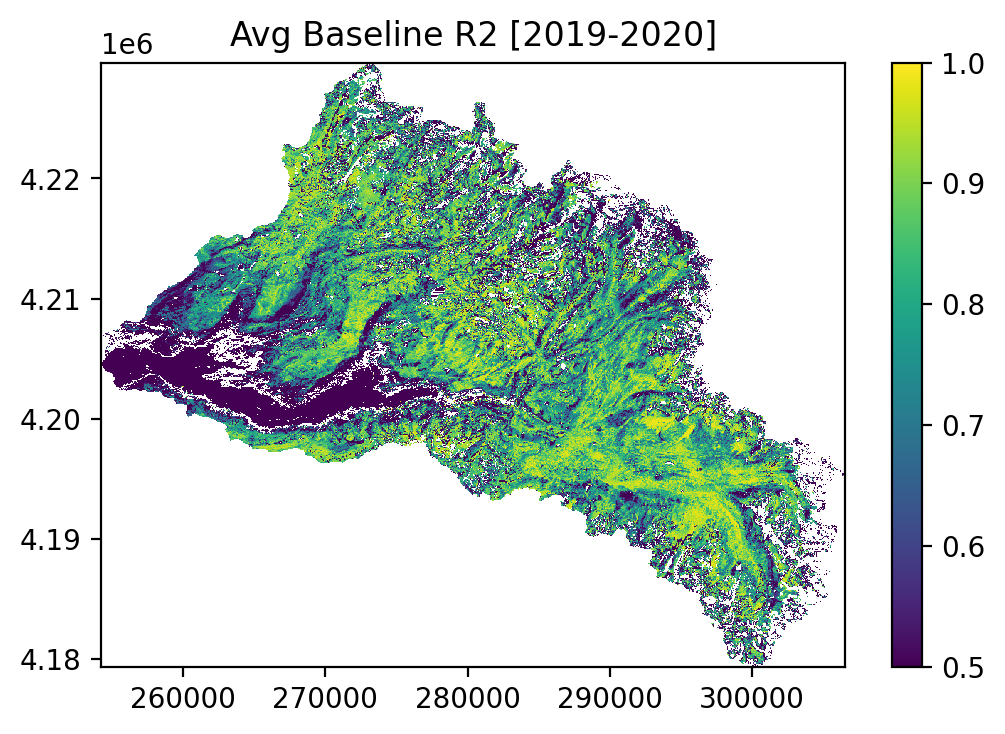

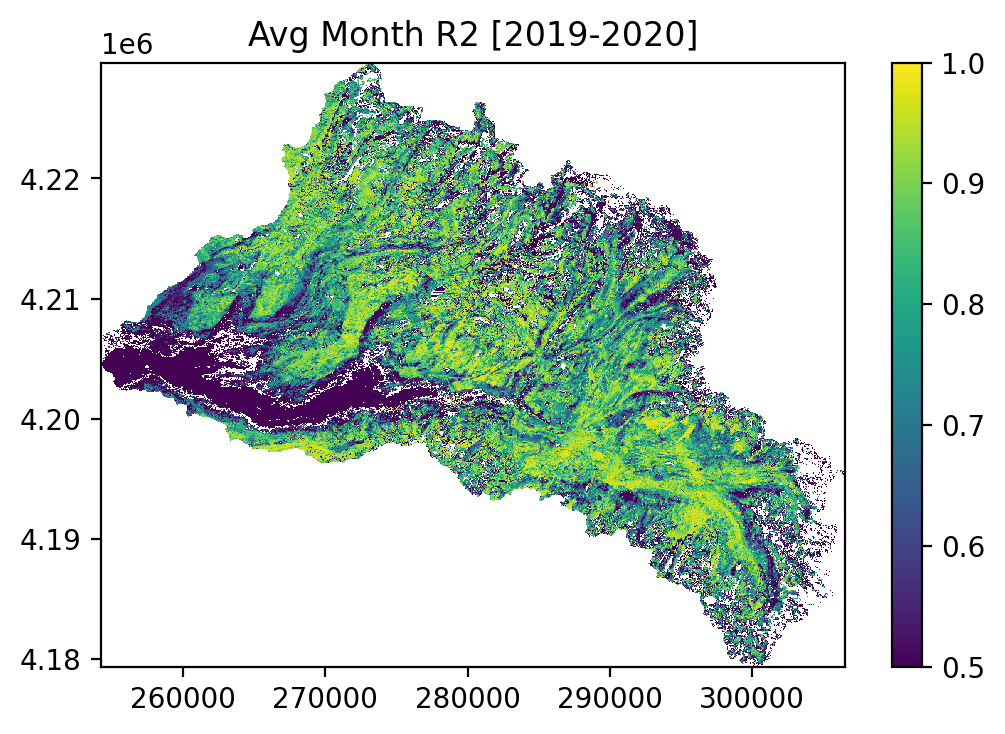

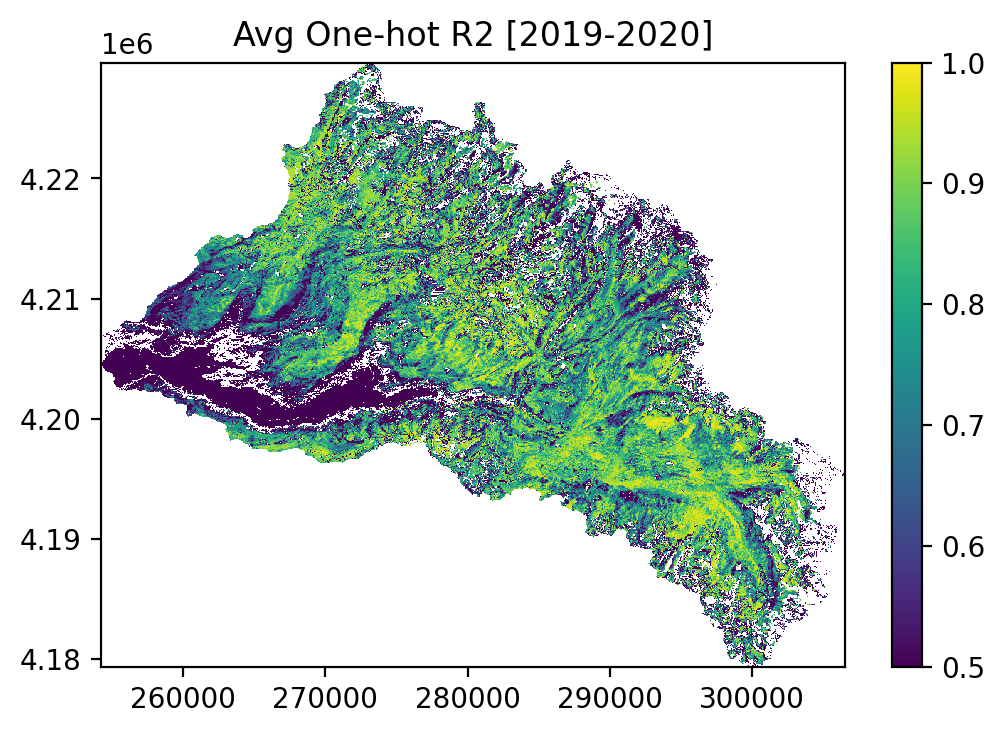

In [12]:
"""
    R2 VALIDATION
"""
fig,ax = plt.subplots(dpi = 200)
plt.pcolormesh(ds_bl.x,ds_bl.y,ds_bl.r2[-1],vmin = 0.5,vmax = 1.0)
plt.title('Avg Baseline R2 [2019-2020]')
plt.colorbar()

fig,ax = plt.subplots(dpi = 200)
plt.pcolormesh(ds_oh.x,ds_oh.y,ds_oh.r2[-1],vmin = 0.5,vmax = 1.0)
plt.title('Avg Month R2 [2019-2020]')
plt.colorbar()

fig,ax = plt.subplots(dpi = 200)
plt.pcolormesh(ds_avg.x,ds_avg.y,ds_avg.r2[-1],vmin = 0.5,vmax = 1.0)
plt.title('Avg One-hot R2 [2019-2020]')
plt.colorbar()

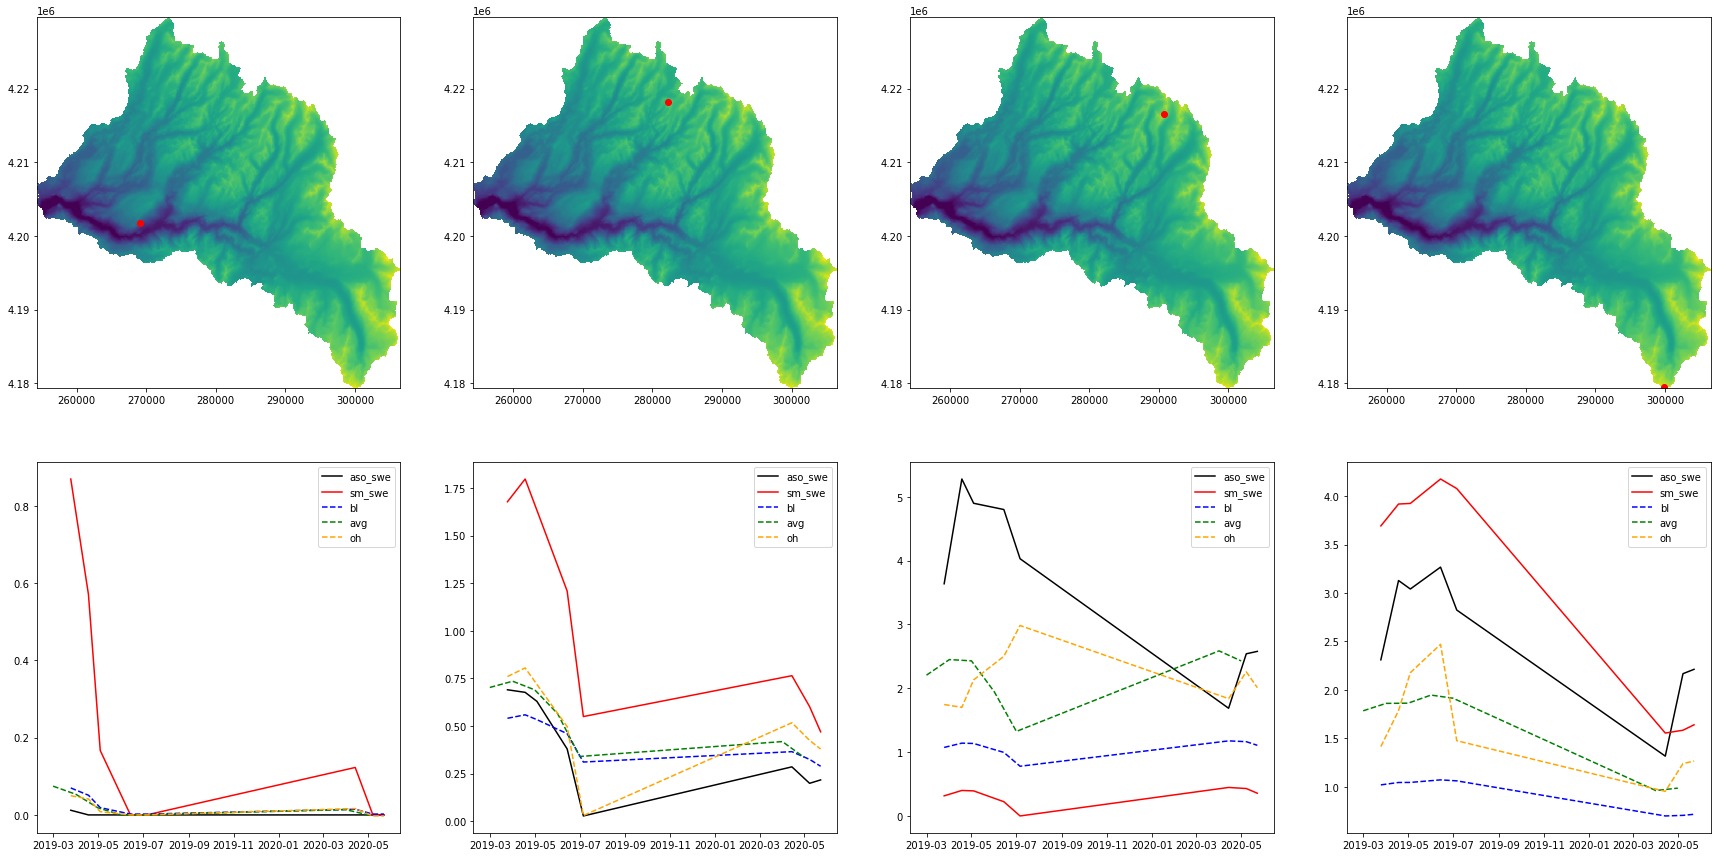

In [13]:
"""
    TIME SERIES COMPARISON
"""

fig,ax = plt.subplots(2,4,figsize = (30,15))
i = 298 # low snow example
j = 447 # low snow example
a = ax[0][0].pcolormesh(ds_bl.x,ds_bl.y,ds.hgt)
ax[0][0].scatter(ds_bl.x[i],ds_bl.y[j],color = 'red')

ax[1][0].plot(ds_bl.time[-8:],ds_bl.aso_swe[-8:,j,i],color = 'black',label = 'aso_swe')
ax[1][0].plot(ds_bl.time[-8:],ds_bl.sm_swe[-8:,j,i],color = 'red',label = 'sm_swe')
ax[1][0].plot(ds_bl.time[-8:],ds_bl.yhat[-8:,j,i],'--',color = 'blue',label = 'bl')
ax[1][0].plot(ds_avg.time[-7:],ds_avg.yhat[-7:,j,i],'--',color = 'green',label = 'avg')
ax[1][0].plot(ds_oh.time[-8:],ds_oh.yhat[-8:,j,i],'--',color = 'orange',label = 'oh')
ax[1][0].legend()

i = 559 # low snow example
j = 776 # low snow example
a = ax[0][1].pcolormesh(ds_bl.x,ds_bl.y,ds.hgt)
ax[0][1].scatter(ds_bl.x[i],ds_bl.y[j],color = 'red')

ax[1][1].plot(ds_bl.time[-8:],ds_bl.aso_swe[-8:,j,i],color = 'black',label = 'aso_swe')
ax[1][1].plot(ds_bl.time[-8:],ds_bl.sm_swe[-8:,j,i],color = 'red',label = 'sm_swe')
ax[1][1].plot(ds_bl.time[-8:],ds_bl.yhat[-8:,j,i],'--',color = 'blue',label = 'bl')
ax[1][1].plot(ds_avg.time[-7:],ds_avg.yhat[-7:,j,i],'--',color = 'green',label = 'avg')
ax[1][1].plot(ds_oh.time[-8:],ds_oh.yhat[-8:,j,i],'--',color = 'orange',label = 'oh')
ax[1][1].legend()

i = 730 # low snow example
j = 744 # low snow example
a = ax[0][2].pcolormesh(ds_bl.x,ds_bl.y,ds.hgt)
ax[0][2].scatter(ds_bl.x[i],ds_bl.y[j],color = 'red')

ax[1][2].plot(ds_bl.time[-8:],ds_bl.aso_swe[-8:,j,i],color = 'black',label = 'aso_swe')
ax[1][2].plot(ds_bl.time[-8:],ds_bl.sm_swe[-8:,j,i],color = 'red',label = 'sm_swe')
ax[1][2].plot(ds_bl.time[-8:],ds_bl.yhat[-8:,j,i],'--',color = 'blue',label = 'bl')
ax[1][2].plot(ds_avg.time[-7:],ds_avg.yhat[-7:,j,i],'--',color = 'green',label = 'avg')
ax[1][2].plot(ds_oh.time[-8:],ds_oh.yhat[-8:,j,i],'--',color = 'orange',label = 'oh')
ax[1][2].legend()

i = 912 # low snow example
j = 1 # low snow example
a = ax[0][3].pcolormesh(ds_bl.x,ds_bl.y,ds.hgt)
ax[0][3].scatter(ds_bl.x[i],ds_bl.y[j],color = 'red')

ax[1][3].plot(ds_bl.time[-8:],ds_bl.aso_swe[-8:,j,i],color = 'black',label = 'aso_swe')
ax[1][3].plot(ds_bl.time[-8:],ds_bl.sm_swe[-8:,j,i],color = 'red',label = 'sm_swe')
ax[1][3].plot(ds_bl.time[-8:],ds_bl.yhat[-8:,j,i],'--',color = 'blue',label = 'bl')
ax[1][3].plot(ds_avg.time[-7:],ds_avg.yhat[-7:,j,i],'--',color = 'green',label = 'avg')
ax[1][3].plot(ds_oh.time[-8:],ds_oh.yhat[-8:,j,i],'--',color = 'orange',label = 'oh')
ax[1][3].legend()

plt.show()



In [14]:
"""
    SUMMARY STATISTICS SM vs. ASO
"""
print('summary stats sm vs aso',)
summary_stats(ds_bl,'sm_swe',-8,isPrediction = False)

summary stats sm vs aso
ASO - SNOWMODEL [DIFF]
average :0.02934919986448247
max :7.530342809855938
min :-4.35921252731766

ASO - SNOWMODEL [MSE]
average :0.09494699689395361
max :64.6802033949044
min :0.0

ASO - SNOWMODEL [RMSE]
average :0.15786413601810245
max :8.042400350324796
min :0.0


In [15]:
"""
    SUMMARY STATISTICS BL vs. ASO
"""

print('summary stats baseline')
summary_stats(ds_bl,'yhat',-8)

summary stats baseline
ASO - SNOWMODEL [DIFF]
average :0.22947168976464866
max :7.177286766933638
min :-0.4080513808394263

ASO - SNOWMODEL [MSE]
average :0.08824033246274682
max :57.002487115871446
min :0.0

ASO - SNOWMODEL [RMSE]
average :0.15799977224611733
max :7.549999146746405
min :0.0

ASO - SNOWMODEL [R2]
average :0.6333586667442189
max :0.9996675411870677
min :0.0
Avg Training R2 : 0.7099317879478062
Avg Testing R2 : 0.5945420656229787


In [16]:
"""
    SUMMARY STATISTICS AVG vs. ASO
"""
print('summary stats avg')
summary_stats(ds_avg,'yhat',-7)

summary stats avg
ASO - SNOWMODEL [DIFF]
average :-0.07082078713370416
max :1.1435037913082622
min :-1.8966213090003963

ASO - SNOWMODEL [MSE]
average :0.022862269008314597
max :14.997247646089928
min :0.0

ASO - SNOWMODEL [RMSE]
average :0.07859744603375257
max :3.872628002544258
min :0.0

ASO - SNOWMODEL [R2]
average :0.6424858315499758
max :0.9990986870212618
min :0.0
Avg Training R2 : 0.7006715823049595
Avg Testing R2 : 0.6337849292367133


In [17]:
"""
    SUMMARY STATISTICS OH vs. ASO
"""

print('summary stats oh')
summary_stats(ds_oh,'yhat',-8)

summary stats oh
ASO - SNOWMODEL [DIFF]
average :0.11727858128266255
max :5.160849609990324
min :-11.167900219054946

ASO - SNOWMODEL [MSE]
average :0.041515143605173485
max :43.66797823515772
min :0.0

ASO - SNOWMODEL [RMSE]
average :0.10496915708959834
max :6.60817510627236
min :0.0

ASO - SNOWMODEL [R2]
average :0.6226550827683051
max :0.9999942740167097
min :0.0
Avg Training R2 : 0.6735329327814578
Avg Testing R2 : 0.5582859570362482


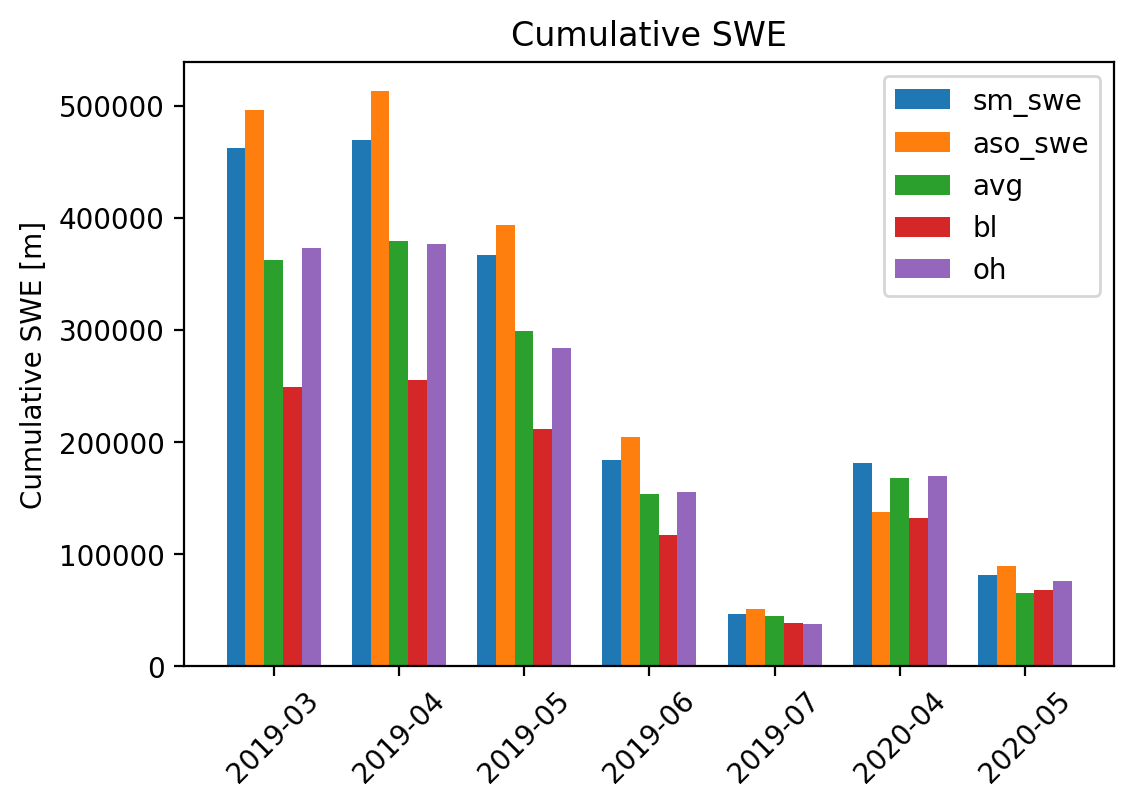

In [18]:
"""
    CUMULATIVE SWE
"""

fig,ax = plt.subplots(dpi = 200)
plt.bar(np.arange(0,7)-0.3,ds_bl.where(np.isnan(ds_bl.yhat) == False)['sm_swe'][-8:-1,:,:].sum(dim = ['y','x'],skipna = True),width = 0.15,label = 'sm_swe')
plt.bar(np.arange(0,7)-0.15,ds_bl.where(np.isnan(ds_bl.yhat) == False)['aso_swe'][-8:-1,:,:].sum(dim = ['y','x'],skipna = True),width = 0.15,label = 'aso_swe')
plt.bar(np.arange(0,7),ds_avg.where(np.isnan(ds_avg.yhat) == False)['yhat'][-7:,:,:].sum(dim = ['y','x'],skipna = True),width = 0.15,label = 'avg')
plt.bar(np.arange(0,7)+ 0.15,ds_bl.where(np.isnan(ds_bl.yhat) == False)['yhat'][-8:-1,:,:].sum(dim = ['y','x'],skipna = True),width = 0.15,label = 'bl')
plt.bar(np.arange(0,7)+0.3,ds_oh.where(np.isnan(ds_oh.yhat) == False)['yhat'][-8:-1,:,:].sum(dim = ['y','x'],skipna = True),width = 0.15,label = 'oh')
plt.title('Cumulative SWE')
plt.ylabel('Cumulative SWE [m]')
plt.xticks(np.arange(0,7),pd.to_datetime(ds_avg.time[-7:].values, format='%Y%m%d').strftime('%Y-%m'),rotation =45)
plt.legend()